In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
%load_ext line_profiler

from coeditor.common import *
import os
from coeditor.model import RetrievalEditorModel, AttentionMode, DecodingArgs, EditCostModel, MultiRoundEvaluator, KeystrokeCostModel
from coeditor.service import EditPredictionService, ChangeDetector
from coeditor.c3problem import C3GeneratorCache, C3Problem, C3ProblemTokenizer

os.chdir(proj_root())

In [2]:
testset: list[C3Problem] = pickle_load(
    get_dataset_dir("perm2k")
    / "processed"
    / "C3ProblemGenerator(VERSION=2.9)"
)["test"]
len(testset)


22501

In [3]:
subset = list[C3Problem]()
for ex in tqdm(testset):
    ex = ex.restrict_span_changes()
    c = ex.span.get_change()
    if len(c.before) <= 6000 and len(c.after) <= 6000:
        subset.append(ex)
print(f"{len(subset)=}")

100%|██████████| 22501/22501 [00:22<00:00, 1004.40it/s]

len(subset)=22501


In [4]:
subset = subset[0:-1:45]
print(f"{len(subset)=}")

len(subset)=500


In [5]:
cm = KeystrokeCostModel()

all_costs = pmap(
    cm.get_edit_gain,
    [ex.span.original.tolist() for ex in subset],
    [ex.span.delta for ex in subset],
)
scalar_stats(all_costs)

pmap: get_edit_gain: 100%|██████████| 500/500 [00:13<00:00, 36.32it/s] 


{'mean': 138.86, 'median': 48.5, 'min': 5.0, 'max': 2681.0}

(array([94., 73., 58., 27., 31., 23., 17.,  9., 12., 21., 10.,  9.,  7.,
         6.,  7.,  5.,  3.,  5.,  5.,  8.,  4.,  3.,  2.,  6.,  1.,  1.,
         1.,  2.,  6.,  2.,  1.,  3.,  3.,  2.,  2.,  1.,  3.,  0.,  1.,
         0.]),
 array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ,
        112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. , 212.5,
        225. , 237.5, 250. , 262.5, 275. , 287.5, 300. , 312.5, 325. ,
        337.5, 350. , 362.5, 375. , 387.5, 400. , 412.5, 425. , 437.5,
        450. , 462.5, 475. , 487.5, 500. ]),
 <BarContainer object of 40 artists>)

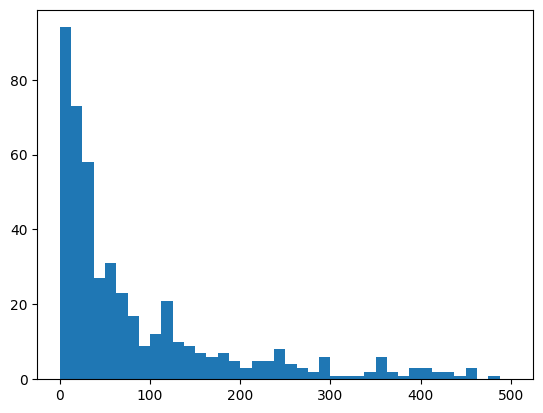

In [6]:
# plot a histogram of the costs
import matplotlib.pyplot as plt

plt.hist(all_costs, bins=40, range=(0, 500))


In [7]:
subset = [ex for i, ex in enumerate(subset) if 20 <= all_costs[i] <= 500]
len(subset)


336

cm = EditCostModel()
%timeit -n 1 -r 3 all_costs = [cm.get_edit_gain(ex.span.original.tolist(), ex.span.delta) for ex in tqdm(testset[:50])]

In [8]:
tokenizer = C3ProblemTokenizer(
    max_query_tks=1024,
    max_ref_tks=1024,
    max_output_tks=512,
    max_ref_tks_sum=1024 * 15,
)
dense_tokenizer = C3ProblemTokenizer(
    max_query_tks=1024,
    max_ref_tks=1024,
    max_output_tks=512,
    max_ref_tks_sum=1024 * 3,
)

model_tkn_map = {
    "coeditor-perm2k-c3-multi-v1.7.3": tokenizer,
    "coeditor-perm2k-c3-multi-dense_attention-v1.7.3": dense_tokenizer,
    "coeditor-perm2k-c3-multi-no_change-v1.7.3": tokenizer,
    "coeditor-perm2k-c3-multi-no_defs-v1.7.2": tokenizer,
}

dec_args = DecodingArgs(do_sample=False, num_beams=1, length_penalty=0.0)

In [9]:
results = dict[str, Any]()
for name, tkn in list(model_tkn_map.items())[2:]:
    print(f"Evaluating {name}...")
    target_dir = proj_root()
    model_path = get_model_dir(True) / name
    model = RetrievalEditorModel.load(model_path)
    model.to("cuda:2")

    evaluator = MultiRoundEvaluator(model, tkn, dec_args, strategy="most_uncertain")
    multi_stats = [
        evaluator.multi_round_edit_gain(ex, print_steps=False)
        for ex in tqdm(subset, smoothing=0.0)
    ]
    results[name] = multi_stats
    model.to("cpu")
    del model


Evaluating coeditor-perm2k-c3-multi-no_change-v1.7.3...


100%|██████████| 336/336 [24:57<00:00,  4.46s/it]


Evaluating coeditor-perm2k-c3-multi-no_defs-v1.7.2...


100%|██████████| 336/336 [26:39<00:00,  4.76s/it]


In [1]:
for name, stats in results.items():
    cm = KeystrokeCostModel()
    cm_name = cm.name
    print(SEP)
    print("Model name:", name)
    stats = [s[cm_name] for s in multi_stats]

    keys = ["label_edit_gain", "first_edit_gain", "total_edit_gain", "rounds"]
    mean_stats = {k: scalar_stats([getattr(s, k) for s in stats]) for k in keys}   
    pretty_print_dict(mean_stats)

    print(f"For all edits (n={len(stats)}):")
    label_sum = sum(s.label_edit_gain for s in stats)
    single_sum = sum(s.first_edit_gain for s in stats)
    multi_sum = sum(s.total_edit_gain for s in stats)
    print(f"Single-round Gain ratio: {single_sum / label_sum:.2%}")
    print(f"Multi-round Gain ratio: {multi_sum / label_sum:.2%}")

NameError: name 'results' is not defined

In [9]:
for cm in evaluator.cost_models:
    cm_name = cm.name
    print(SEP)
    print("Cost model:", cm_name)
    stats = [s[cm_name] for s in multi_stats]

    keys = ["label_edit_gain", "first_edit_gain", "total_edit_gain", "rounds"]
    mean_stats = {k: scalar_stats([getattr(s, k) for s in stats]) for k in keys}   
    pretty_print_dict(mean_stats)

    print(f"For all edits (n={len(stats)}):")
    label_sum = sum(s.label_edit_gain for s in stats)
    single_sum = sum(s.first_edit_gain for s in stats)
    multi_sum = sum(s.total_edit_gain for s in stats)
    print(f"Single-round Gain ratio: {single_sum / label_sum:.2%}")
    print(f"Multi-round Gain ratio: {multi_sum / label_sum:.2%}")

    # big_stats = [s for s in stats if 100 <= s.label_edit_gain]
    # print(f"For big edits (n={len(big_stats)}):")
    # label_sum = sum(s.label_edit_gain for s in big_stats)
    # single_sum = sum(s.first_edit_gain for s in big_stats)
    # multi_sum = sum(s.total_edit_gain for s in big_stats)
    # print(f"Single-round Gain ratio: {single_sum / label_sum:.2%}")
    # print(f"Multi-round Gain ratio: {multi_sum / label_sum:.2%}")

--------------------------------------------------------------------------------
Cost model: keystrokes
label_edit_gain: {mean: 149.09, median: 113, min: 50, max: 498}
first_edit_gain: {mean: 44.772, median: 16, min: 0, max: 467}
total_edit_gain: {mean: 63.585, median: 51, min: -155, max: 459}
rounds: {mean: 3.1638, median: 3, min: 1, max: 8}
For all edits (n=1587):
Single-round Gain ratio: 30.03%
Multi-round Gain ratio: 42.65%
--------------------------------------------------------------------------------
Cost model: diff-lines
label_edit_gain: {mean: 66.928, median: 53, min: 8, max: 631}
first_edit_gain: {mean: 23.029, median: 9, min: 0, max: 452}
total_edit_gain: {mean: 36.101, median: 26, min: 0, max: 530}
rounds: {mean: 3.1638, median: 3, min: 1, max: 8}
For all edits (n=1587):
Single-round Gain ratio: 34.41%
Multi-round Gain ratio: 53.94%
--------------------------------------------------------------------------------
Cost model: levenshtein
label_edit_gain: {mean: 157.9, median

In [3]:
# find the first index where the edit gain is less than 0
ex_id = random.choice([i for i, s in enumerate(multi_stats) if s["levenshtein"].rounds > 1 and s["levenshtein"].label_edit_gain > s["levenshtein"].total_edit_gain > 90])
ex = subset[ex_id]
ex.print()

NameError: name 'random' is not defined